In [7]:
import torch
from librosa.filters import mel as librosa_mel_fn

mel_basis = {}
hann_window = {}

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def mel_spectrogram(
    y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False
):
    if torch.min(y) < -1.0:
        print("min value is ", torch.min(y))
    if torch.max(y) > 1.0:
        print("max value is ", torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(
            sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax
        )
        mel_basis[str(fmax) + "_" + str(y.device)] = (
            torch.from_numpy(mel).float().to(y.device)
        )
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(
        y.unsqueeze(1),
        (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
        mode="reflect",
    )
    y = y.squeeze(1)

    spec = torch.stft(
        y,
        n_fft,
        hop_length=hop_size,
        win_length=win_size,
        window=hann_window[str(y.device)],
        center=center,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=False,
    )

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))

    spec = torch.matmul(mel_basis[str(fmax) + "_" + str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [11]:
import math
from jax import numpy as jnp, lax
from typing import Any, Optional

def batch_pad(xs, pad: int, mode="reflect"):
    if xs.ndim == 2:
        pad_arg = [(0, 0), (pad, pad)]
    elif xs.ndim == 3:
        pad_arg = [(0, 0), (pad, pad), (0, 0)]
    else:
        pad_arg = [(pad, pad)]
    xs = jnp.pad(xs, pad_arg, mode=mode)
    return xs


def _conv_dimension_numbers(input_shape):
    """Computes the dimension numbers based on the input shape."""
    ndim = len(input_shape)
    lhs_spec = (0, ndim - 1) + tuple(range(1, ndim - 1))
    rhs_spec = (ndim - 1, ndim - 2) + tuple(range(0, ndim - 2))
    out_spec = lhs_spec
    return lax.ConvDimensionNumbers(lhs_spec, rhs_spec, out_spec)

def stft(inputs: jnp.array, n_fft: int, hop_length: Optional[int] = None,
         win_length: Optional[int] = None, window: Optional[jnp.array] = None,
         center: bool = True,
         onesided: Optional[bool] = None) -> jnp.array:
    r"""Short-time fourier transform
    This implementation is designed to be consistent with stft implementation from torchaudio
    and does not have all the bells and whistles from scipy.signal.

    Get's the job done though, run's on GPUs and TPUs, and produces identical output to the torchaudio implementation
    in very few lines of code.

    It uses `lax.conv_general_dilated_patches` to generate overlapping patches.

    Returns a jnp.array of size :math:`(* \times T \times N)`, where :math:`*` is the optional batch size of
    :attr:`input`, :math:`N` is the number of frequencies where STFT is applied
    and :math:`T` is the total number of frames used.

    Args:
        input (jnp.array): input signal tensor of shape (T,), (N, T) or (N, T, 1)
        n_fft (int): size of Fourier transform
        hop_length (int, optional): the distance between neighboring sliding window
            frames. Default: ``None`` (treated as equal to ``floor(n_fft / 4)``)
        win_length (int, optional): the size of window frame and STFT filter.
            Default: ``None``  (treated as equal to :attr:`n_fft`)
        window (Tensor, optional): the optional window function.
            Default: ``None`` (treated as window of all :math:`1` s)
        center (bool, optional): whether to pad :attr:`input` on both sides via reflection padding
            so that the :math:`t`-th frame is centered at time :math:`t \times \text{hop\_length}`.
            Default: ``True``
        onesided (bool, optional): controls whether to return half of results to
            avoid redundancy for real inputs.
            Default: ``True`` for real :attr:`input` and :attr:`window`, ``False`` otherwise.
    Returns:
        jnp.array, as described above
    """

    is_real = inputs.dtype == jnp.float32

    assert window.shape[-1] == win_length
    win_length = win_length if win_length is not None else n_fft
    hop_length = hop_length if hop_length is not None else n_fft // 4

    input_dims = inputs.ndim
    single_input = False
    if input_dims == 1:
        inputs = inputs.reshape(1, -1, 1)
        single_input = True
    if input_dims == 2:
        # assuming first dimension is batch, second is time
        inputs = inputs[Ellipsis, jnp.newaxis]

    if center:
        pad = int(n_fft // 2)
        inputs = batch_pad(inputs, pad=pad)

    dimension_numbers = _conv_dimension_numbers(inputs.shape)
    strided = lax.conv_general_dilated_patches(lhs=inputs, filter_shape=(win_length,),
                        window_strides=(hop_length,), padding='VALID',
                        dimension_numbers=dimension_numbers)

    # apply window
    strided = strided * window.reshape(1, 1, -1)
    output = jnp.fft.fft(strided, n=n_fft)

    if onesided is None:
        if is_real:
            onesided = True

    if onesided:
        output = output[:, :, :(n_fft // 2) + 1]

    return output



def _hz_to_mel(freq: float, mel_scale: str = "htk") -> float:
    r"""Convert Hz to Mels.

    Args:
        freqs (float): Frequencies in Hz
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        mels (float): Frequency in Mels
    """
    if mel_scale not in ['slaney', 'htk']:
        raise ValueError('mel_scale should be one of "htk" or "slaney".')

    if mel_scale == "htk":
        return 2595.0 * math.log10(1.0 + (freq / 700.0))

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (freq - f_min) / f_sp
    min_log_hz = 1000.0
    min_log_mel = (min_log_hz - f_min) / f_sp
    logstep = math.log(6.4) / 27.0

    if freq >= min_log_hz:
        mels = min_log_mel + math.log(freq / min_log_hz) / logstep
    return mels


def _mel_to_hz(mels: jnp.array, mel_scale: str = "htk") -> jnp.array:
    """Convert mel bin numbers to frequencies.

    Args:
        mels (jnp.array): Mel frequencies
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        freqs (Tensor): Mels converted in Hz
    """
    if mel_scale not in ['slaney', 'htk']:
        raise ValueError('mel_scale should be one of "htk" or "slaney".')
    if mel_scale == "htk":
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)
    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0
    min_log_mel = (min_log_hz - f_min) / f_sp
    logstep = math.log(6.4) / 27.0

    log_t = (mels >= min_log_mel)
    freqs.at[log_t].set(min_log_hz * jnp.exp(logstep * (mels[log_t] - min_log_mel)))
    return freqs


def _create_triangular_filterbank(
        all_freqs: jnp.array,
        f_pts: jnp.array,
) -> jnp.array:
    """Create a triangular filter bank.

    Args:
        all_freqs (Tensor): STFT freq points of size (`n_freqs`).
        f_pts (Tensor): Filter mid points of size (`n_filter`).

    Returns:
        fb (Tensor): The filter bank of size (`n_freqs`, `n_filter`).
    """
    # Adopted from Librosa
    # calculate the difference between each filter mid point and each stft freq point in hertz
    f_diff = f_pts[1:] - f_pts[:-1]  # (n_filter + 1)
    slopes = f_pts[jnp.newaxis, Ellipsis] - all_freqs[Ellipsis, jnp.newaxis]  # (n_freqs, n_filter + 2)
    # create overlapping triangles
    down_slopes = (-1.0 * slopes[:, :-2]) / f_diff[:-1]  # (n_freqs, n_filter)
    up_slopes = slopes[:, 2:] / f_diff[1:]  # (n_freqs, n_filter)
    fb = jnp.maximum(0., jnp.minimum(down_slopes, up_slopes))
    return fb

def melscale_fbanks(
        n_freqs: int,
        n_mels: int,
        sample_rate: int,
        f_min: float,
        f_max: Optional[float] = None,
        norm: Optional[str] = None,
        mel_scale: str = "htk",
) -> jnp.array:
    r"""Create a frequency bin conversion matrix.

    Args:
        n_freqs (int): Number of frequencies to highlight/apply
        f_min (float): Minimum frequency (Hz)
        f_max (float): Maximum frequency (Hz)
        n_mels (int): Number of mel filterbanks
        sample_rate (int): Sample rate of the audio waveform
        norm (str or None, optional): If 'slaney', divide the triangular mel weights by the width of the mel band
            (area normalization). (Default: ``None``)
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        Tensor: Triangular filter banks (fb matrix) of size (``n_freqs``, ``n_mels``)
        meaning number of frequencies to highlight/apply to x the number of filterbanks.
        Each column is a filterbank so that assuming there is a matrix A of
        size (..., ``n_freqs``), the applied result would be
        ``A * melscale_fbanks(A.size(-1), ...)``.

    """
    f_max = f_max if f_max is not None else float(sample_rate // 2)
    assert f_min <= f_max, 'Require f_min: {} < f_max: {}'.format(f_min, f_max)
    if norm is not None and norm != "slaney":
        raise ValueError("norm must be one of None or 'slaney'")
    all_freqs = jnp.linspace(0, sample_rate // 2, n_freqs)

    # calculate mel freq bins
    m_min = _hz_to_mel(f_min, mel_scale=mel_scale)
    m_max = _hz_to_mel(f_max, mel_scale=mel_scale)

    m_pts = jnp.linspace(m_min, m_max, n_mels + 2)
    f_pts = _mel_to_hz(m_pts, mel_scale=mel_scale)

    # create filterbank
    fb = _create_triangular_filterbank(all_freqs, f_pts)

    if norm is not None and norm == "slaney":
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (f_pts[2:n_mels + 2] - f_pts[:n_mels])
        fb *= enorm[jnp.newaxis, Ellipsis]

    # if (fb.max(axis=0) == 0.).any():
    #     warnings.warn(
    #         "At least one mel filterbank has all zero values. "
    #         f"The value for `n_mels` ({n_mels}) may be set too high. "
    #         f"Or, the value for `n_freqs` ({n_freqs}) may be set too low."
    #     )

    return fb
def spectrogram(
        inputs: jnp.array,
        pad: int,
        window: jnp.array,
        n_fft: int,
        hop_length: int,
        win_length: int,
        power: Optional[float] = 2.0,
        normalized: bool = False,
        center: bool = True,
        onesided: bool = True,
        return_complex: bool = True
) -> jnp.array:
    r"""Create a spectrogram or a batch of spectrograms from a raw audio signal.
        The spectrogram can be either magnitude-only or complex.

        Args:
            inputs (Tensor): Tensor of audio of dimension `(..., time)`
            pad (int): Two sided padding of signal
            window (Tensor): Window tensor that is applied/multiplied to each frame/window
            n_fft (int): Size of FFT
            hop_length (int): Length of hop between STFT windows
            win_length (int): Window size
            power (float or None): Exponent for the magnitude spectrogram,
                (must be > 0) e.g., 1 for energy, 2 for power, etc.
                If None, then the complex spectrum is returned instead.
            normalized (bool): Whether to normalize by magnitude after stft
            center (bool, optional): whether to pad :attr:`waveform` on both sides so
                that the :math:`t`-th frame is centered at time :math:`t \times \text{hop\_length}`.
                Default: ``True``
            pad_mode (string, optional): controls the padding method used when
                :attr:`center` is ``True``. Default: ``"reflect"``
            onesided (bool, optional): controls whether to return half of results to
                avoid redundancy. Default: ``True``
            return_complex (bool, optional):
                Indicates whether the underlying complex valued spectrogram is to be returned.
                If False, absolute value of the spectrogram is returned
                This argument is only effective when ``power=None``. It is ignored for
                cases where ``power`` is a number as in those cases, the returned tensor is
                power spectrogram, which is a real-valued tensor.

        Returns:
            Tensor: Dimension `(..., freq, time)`, freq is
            ``n_fft // 2 + 1`` and ``n_fft`` is the number of
            Fourier bins, and time is the number of window hops (n_frame).
        """
    if power is None and not return_complex:
        raise ValueError(f"in correct combination of power(={power}) and return_complex(={return_complex}) provided.")

    if pad > 0:
        inputs = batch_pad(inputs, pad, "zeros")

    spec_f = stft(
        inputs,
        n_fft,
        hop_length,
        win_length,
        window,
        center=center,
        onesided=onesided
    )

    if normalized:
        spec_f /= jnp.sqrt(jnp.sum(jnp.power(window, 2.)))

    if power is not None:
        if power == 1.0:
            return jnp.abs(spec_f)
        return jnp.power(jnp.abs(spec_f), power)
    if not return_complex:
        return jnp.abs(spec_f)
    return spec_f


def apply_melscale(spectrogram: jnp.array,
                   melscale_filterbank: jnp.array,
                   precision: Any = lax.Precision.HIGHEST) -> jnp.array:
    r"""

    Args:
        spectrogram (jnp.array): A spectrogram STFT of dimension (..., time, freq)
        melscale_filterbank (jnp.array): MelScale filterbank of dimension (``n_freqs``, ``n_mels``)
        precision (jax.lax.Precision): Precision enum. Default value is  Precision.HIGHEST, which corresponds to FP32

    Returns
        jnp.array: A melspectrogram of dimension (..., time, ``n_mels``)
    """
    melspec = jnp.matmul(spectrogram, melscale_filterbank, precision=precision)
    return melspec

import soundfile as sf
import jax.numpy as jnp
from functools import partial

# creates a spectrogram helper
window = jnp.hanning(1024)
spec_func = partial(spectrogram, pad=0, window=window, n_fft=1024,
                   hop_length=256, win_length=1024, power=2.,
                   normalized=False, center=False, onesided=True)
fb = melscale_fbanks(n_freqs=(1024//2)+1, n_mels=80,
                         sample_rate=22050, f_min=0., f_max=8000.)
mel_spec_func = partial(apply_melscale, melscale_filterbank=fb)


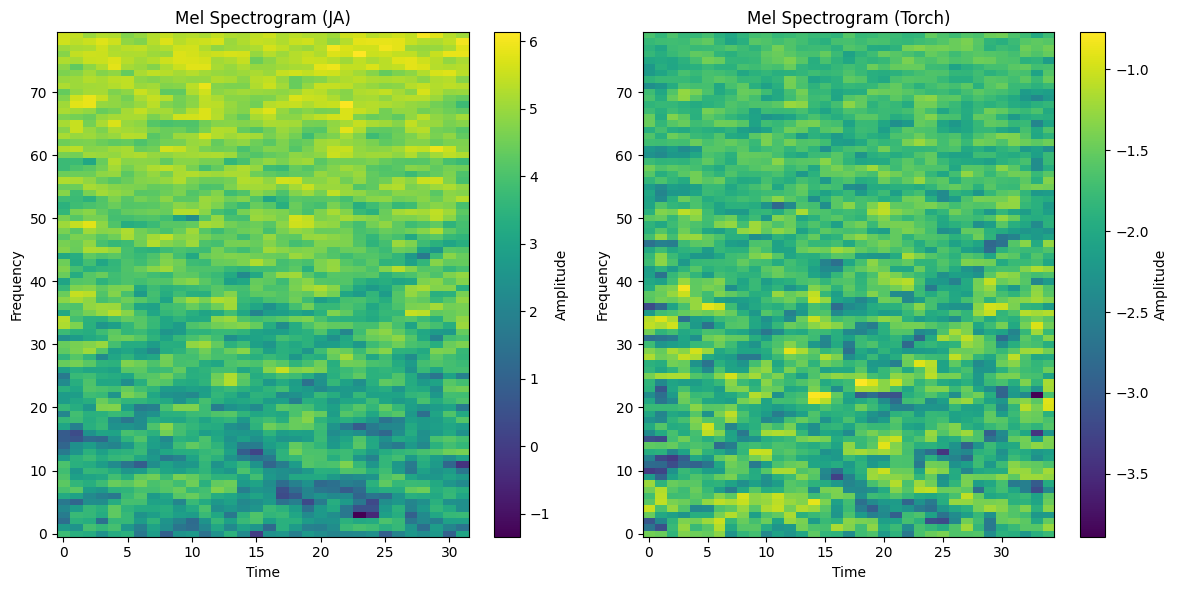

In [22]:
from librosa.util import normalize
import jax
import numpy as np

from hifigan import mel_spec_base

RANDOM = jax.random.PRNGKey(1)
SEGMENT_SIZE = 8192

def transform(wav):
    """Based off the original code that can be found here: https://github.com/jik876/hifi-gan/blob/master/meldataset.py

    Args:
        sample (dict): dict entry in HF Dataset

    Returns:
        dict: updated entry
    """
    global RANDOM, SAMPLE_RATE

    RANDOM, k = jax.random.split(RANDOM)
    wav = normalize(wav) * 0.95
    if wav.shape[0] >= SEGMENT_SIZE:
        max_audio_start = wav.shape[0] - SEGMENT_SIZE
        audio_start = jax.random.randint(k, (1,), 0, max_audio_start)[0]
        wav = wav[audio_start : audio_start + SEGMENT_SIZE]

    wav = np.expand_dims(wav, 0)
    # mel = mel_spec_base(wav=wav)
    wav = np.pad(
        wav,
        ((0, 0), (int((1024 - 256) / 2), int((1024 - 256) / 2))),
        mode="reflect",
    )
    jax_spec = spec_func(wav)
    mel = mel_spec_func(jax_spec) 
    mel = jnp.log(jnp.clip(mel, min=1e-5))  # Spectral normalization

    torch_mel = mel_spectrogram(torch.from_numpy(wav).type(dtype=torch.float), n_fft=1024, hop_size=256, win_size=1024, num_mels=80, fmin=0, fmax=8000, sampling_rate=22050, center=False)


    return mel, torch_mel

import matplotlib.pyplot as plt

# Mock wav data
wav = jax.random.normal(jax.random.key(1), shape=(8192,))

# Assuming `transform` returns two mel spectrograms (from your base and Torch implementation)
ja_mel, tor_mel = transform(wav)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# First subplot for the "ja" mel spectrogram
plt.subplot(1, 2, 1)
plt.title("Mel Spectrogram (JA)")
plt.imshow(jnp.swapaxes(ja_mel[0], axis1=0, axis2=1), aspect="auto", origin="lower", interpolation="none")
plt.colorbar(label="Amplitude")
plt.xlabel("Time")
plt.ylabel("Frequency")

# Second subplot for the "torch" mel spectrogram
plt.subplot(1, 2, 2)
plt.title("Mel Spectrogram (Torch)")
plt.imshow(tor_mel[0], aspect="auto", origin="lower", interpolation="none")
plt.colorbar(label="Amplitude")
plt.xlabel("Time")
plt.ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()